### question 1

In [1]:
import pandas as pd
import numpy as np
impor
import copy

C:\Users\YunTian\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\YunTian\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\YunTian\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load and preprocess data
We first read the csv file using the Pandas library


Then we process the times in order to find the time taken to travel between two stations

In [2]:
''' Read the csv file'''
df = pd.read_csv("./mrt_trips_sampled.csv")

In [3]:
''' convert the times to a proper format '''
df['destination_tm'] = pd.to_datetime(df['destination_tm'],format= '%H:%M:%S' ).dt.time
df['origin_tm'] = pd.to_datetime(df['origin_tm'],format= '%H:%M:%S' ).dt.time

In [4]:
# this will take a while as no multiprocessing library is used
''' once time format is converted, take the diff between the times as seconds'''
df['time_taken_secs'] = (pd.to_datetime(df['destination_tm'].astype(str)) - pd.to_datetime(df['origin_tm'].astype(str)))

##### Here we are computing the average time time taken between each station

###### Assumption:
I assume this computation of the average of time between two stations is accurate

Otherwise would have to cater for different time periods of the day

i.e. during rush hour, avg time taken would be lower vs during non rush hours

and that the destination tm covers many different time periods i.e. from 9 am to 8 pm

In [5]:
df.time_taken_secs = df.time_taken_secs / np.timedelta64(1, 's')

In [6]:
df.head()

,index,destination,destination_tm,origin,origin_tm,time_taken_secs
0,0,Bugis DTL,10:04:47,Stevens,09:52:23,744.0
1,1,Kent Ridge,10:11:34,Sengkang,09:27:41,2633.0
2,2,Tai Seng,09:35:59,Compassvale,09:03:44,1935.0
3,3,Labrador Park,09:45:50,Bishan NSEW,09:14:45,1865.0
4,4,Joo Koon,09:27:32,Boon Lay,09:20:36,416.0


In [7]:
# destination time latest time is 8 pm
df[['destination_tm']].max()

destination_tm    20:44:47
dtype: object

In [8]:
# destination tim ranges from 9 am to 9 pm
df[['destination_tm']].min()

destination_tm    09:00:35
dtype: object

In [9]:
# vs origin tm which ranges from 9am to 10am
df[['origin_tm']].max()

origin_tm    09:59:59
dtype: object

In [10]:
df[['origin_tm']].min()

origin_tm    09:00:00
dtype: object

##### Here I do some light exploring

to try to understand the data and see what we can do to improve the dataset for reconstructing the underlying structure

In [11]:
# some station pairs have alot more observations, i.e. Admiralty to Ang Mo Kio, vs to Bartley
df[df['origin'] == 'Admiralty'].groupby(['origin', 'destination']).size()

origin     destination 
Admiralty  Admiralty        12
           Aljunied         33
           Ang Mo Kio      408
           Bartley           3
           Bayfront CCL     57
                          ... 
           Woodlands       312
           Yew Tee          87
           Yio Chu Kang    417
           Yishun          285
           one-north        81
Length: 100, dtype: int64

In [12]:
# not all station pairs have data, 
# i.e. Admiralty to dest have 100 unique pairs, whereas Aljunied to dest have 107 unique pairs
df[df['origin'] == 'Aljunied'].groupby(['origin', 'destination']).size()

origin    destination 
Aljunied  Admiralty       12
          Aljunied        15
          Ang Mo Kio      12
          Bakau            3
          Bartley          9
                          ..
          Woodlands       18
          Yew Tee          6
          Yio Chu Kang    15
          Yishun          12
          one-north       18
Length: 107, dtype: int64

##### Top 10 most common station pairs

In [13]:
df.groupby(['origin', 'destination']).size().nlargest(10)

origin       destination  
Ang Mo Kio   Orchard          1398
Toa Payoh    Orchard          1152
             Novena           1041
Tiong Bahru  Raffles Place    1032
Ang Mo Kio   Novena            990
Yishun       Orchard           954
Pasir Ris    Tampines NSEW     909
Bedok        Raffles Place     888
Ang Mo Kio   Raffles Place     807
Boon Lay     Jurong East       807
dtype: int64

In [14]:
# Admiralty as the origin station appears totally in nsmallest
# the dataset is in some ways unbalanced
# this means that we cannot use the distributions of origin station for q3 
# i.e. cannot use this % to calculate out of Singapore's population that takes MRT, how many takes from Admiralty etc..
df.groupby(['origin', 'destination']).size().nsmallest(10)

origin     destination  
Admiralty  Bartley          3
           Caldecott        3
           Chinatown DTL    3
           Coral Edge       3
           Fajar            3
           Farrer Road      3
           Jelapang         3
           Nibong           3
           Phoenix          3
           Simei            3
dtype: int64

###### Here we compute the pair of stations where time taken between them is the longest as well as occurences

this aggregated data can be useful to identify if there are any trip where people often take, and also take a long time

in turn this info can be used to improve maybe things like frequency of trains etc..

##### Some problems with the dataset

the data seems to have errorneous samples, i.e. Bras Basah to Bras Basah takes 17708 avg time in sec

also the destination col, some pairs have occurences count of just 3, not very reliable

so we filter out only those with occurences > 30

In [15]:
aggregated = df[['origin', 'destination', 'time_taken_secs']]\
    .groupby(['origin', 'destination'])\
    .agg({'time_taken_secs': 'mean', 'destination': 'size'})\
    .nlargest(10, columns='time_taken_secs')\
    .rename(columns={'time_taken_secs':'avg_time_taken(sec)', 'destination':'occurences'})

In [16]:
# Filtered out those with > 70 occurences
# as expected, those longest trip are those that are like travelling from east to west or north to south
# new mrt lines are expected to help improve some of these timings

In [17]:
NUM_DISPLAY = 10
count = 0

for row in aggregated.iterrows():
    if row[1][1] > 70: 
        src = (row[0][0])
        dest = (row[0][1])
        if src != dest:
            print(src,"->", dest, "| Avg Time:",round(row[1][0],3), "| Occurences:",row[1][1])
            print("")
            count += 1
        
    if count == NUM_DISPLAY:
        break

##### Lets check what is going on in the nsmallest case

noticed that there is a case of terms like: Marine Bay CCL, Marine Bay or HBF NEL and HBF CCL

in this assignment, I will feign ignorance and assume that they are different

meaning I will not convert them to same station name

In [18]:
df[['origin', 'destination', 'time_taken_secs']]\
    .groupby(['origin', 'destination'])\
    .agg({'time_taken_secs': 'mean', 'destination': 'size'})\
    .nsmallest(10, columns='time_taken_secs')

,,time_taken_secs,destination
origin,destination,,
Petir,Petir,11.0,3
Sam Kee,Sam Kee,14.0,3
Promenade,Promenade,15.0,3
Teck Whye,Teck Whye,17.0,3
Bayfront CCL,Bayfront CCL,19.0,3
Compassvale,Compassvale,23.5,6
Rochor,Paya Lebar NSEW,28.0,3
Marina Bay CCL,Marina Bay,32.0,12
HarbourFront NEL,HarbourFront CCL,34.0,3


In [19]:
# more errorneous data, where moving between two stations took just seconds
# i will remove these samples as it is just not realistic, even if we have no idea of the underlying mrt structure

df[(df['origin']=='Rochor') & (df['destination']=='Paya Lebar NSEW')]

,index,destination,destination_tm,origin,origin_tm,time_taken_secs
21581,21581,Paya Lebar NSEW,09:13:49,Rochor,09:13:21,28.0
148673,148673,Paya Lebar NSEW,09:13:49,Rochor,09:13:21,28.0
275754,275754,Paya Lebar NSEW,09:13:49,Rochor,09:13:21,28.0


##### some station pairs do not have samples

nothing we can do about this

In [20]:
# also some station pairs do not have data, i.e. between punggol and pasir ris

df[(df['origin']=='Punggol') & (df['destination']=='Pasir Ris')]

,index,destination,destination_tm,origin,origin_tm,time_taken_secs


In [21]:
df['origin'].nunique()

154

In [22]:
# the number of dest and origin stations are not the same, 154 vs 153
# this might cause some trouble later, but no worries for now
df['destination'].nunique()

153

##### Check if a origin to dest and dest to origin has same timing

In [23]:
# origin as jurong east and dest as pasir ris
# takes 6863 seconds
check = df[(df['origin']=='Jurong East') & (df['destination']== 'Pasir Ris')]
check.mean()

index              201172.541667
time_taken_secs      6863.500000
dtype: float64

In [24]:
# pasir ris to jurong east takes way lesser time
# now this is just not realistic, if there is a route with lesser time, why not take that route in the first place
check = df[(df['origin']=='Pasir Ris') & (df['destination']== 'Jurong East')]
check.mean()

index              197495.645833
time_taken_secs      3798.875000
dtype: float64

##### Assumption
1) time to go from a station to another and back should be the same 

Since there are samples where origin to dest and back do not have same time

In subsequent section, i will take the average of origin to dest

and dest to origin as the value for all station pairs


In [25]:
# get a count of number of rows before we remove some of them
df.count()

index              381249
destination        381249
destination_tm     381249
origin             381249
origin_tm          381249
time_taken_secs    381249
dtype: int64

### Removing errorneous samples

Lets remove those samples with errorneous data

In [26]:
# remove cases where origin and dest are the same
df = df[df['destination'] != df['origin']]
df.count()

index              379218
destination        379218
destination_tm     379218
origin             379218
origin_tm          379218
time_taken_secs    379218
dtype: int64

In [27]:
# assume that those with avg_time_taken of less than 5 minutes are errorneous
time_threshold = 60 * 5
df = df[df['time_taken_secs'] >= time_threshold]
df.count()

index              369558
destination        369558
destination_tm     369558
origin             369558
origin_tm          369558
time_taken_secs    369558
dtype: int64

In [28]:
# unfortunately, we cannot remove samples where time_taken_secs is several hours long
# since do not know underlying structure

# time_threshold = 60 * 60 * 2
# df = df[df['time_taken_secs'] < time_threshold]
# df.count()

In [29]:
# keep the original df just in case
original_df = copy.deepcopy(df)

In [30]:
# lets see what are the num of rows we are left with
df = df[['destination', 'origin', 'time_taken_secs']]
df

,destination,origin,time_taken_secs
0,Bugis DTL,Stevens,744.0
1,Kent Ridge,Sengkang,2633.0
2,Tai Seng,Compassvale,1935.0
3,Labrador Park,Bishan NSEW,1865.0
4,Joo Koon,Boon Lay,416.0
...,...,...,...
381244,Promenade,Kembangan,1611.0
381245,Bugis NSEW,Bedok,1037.0
381246,HarbourFront NEL,Punggol,2388.0
381247,one-north,Raffles Place,1407.0


##### Organize the processed data into a format that we can easily use

Before we can construct the underlying MRT structure, we need to organize the data into a format we can easily use

1) First, map station names to a unique id

2) Create dictionaries that can translate station names to their id and back

3) find the average time taken to travel between two stations

In [31]:
# 1) map station names to a unique id

name_to_id = dict()
id_to_name = dict()

''' takes the dataframe and assign unique ids to each station name
    give each station name a unique id starting from 0 '''

def create_name_to_id_mapping(df):
    count = 0
    for stn in df.destination.to_list()+df.origin.to_list(): # loop each station and give it a unique id
        stn = str(stn).strip().lower()
        if not stn in name_to_id:
            name_to_id[stn] = count
            id_to_name[count] = stn
            count += 1

In [32]:
create_name_to_id_mapping(df)
print(len(name_to_id), len(id_to_name))

154 154


In [33]:
# 2) Create dictionaries that can translate station names to their id and back

unique_stations = dict()
count_source_to_dest = dict()

''' extract the data out row by row
    inefficient and takes some time, 
    but cannot be parallized since count_source_to_dest is counting '''

def organize_data(df):
    for idx, row in df.iterrows():
        
        # normalize the data to standard form (lowercase, strip whitespaces)
        dest_stn = str(row.destination).strip().lower()
        dest_stn_id = name_to_id[dest_stn]
        origin_stn = str(row.origin).strip().lower()
        origin_stn_id = name_to_id[origin_stn]
        time_taken = row.time_taken_secs
        
        
        # count number of times from origin to destination station in a seperate dictionary
        if not (origin_stn+dest_stn) in count_source_to_dest: 
            count_source_to_dest[(origin_stn+dest_stn)] = 1
        else: 
            count_source_to_dest[(origin_stn+dest_stn)] += 1
        
        
        # create a dictionary for each origin station, and store all the destination stations and all the recorded timings
        if not origin_stn_id in unique_stations:
            unique_stations[origin_stn_id] = dict()
            d = unique_stations[origin_stn_id]
            d[dest_stn_id] = [time_taken]
        else:
            d = unique_stations[origin_stn_id]
            if not dest_stn_id in d:
                d[dest_stn_id] = [time_taken]
            else:
                d[dest_stn_id].append(time_taken)

In [34]:
# this will take some time ~ 10 to 20 secs
import time
start = time.time()

organize_data(df)
print("Organizing data took:", time.time() - start, "secs")

Organizing data took: 13.406587600708008 secs


In [35]:
temp_unique_stations = copy.deepcopy(unique_stations)

In [36]:
# 3) find the average time taken to travel between two stations


''' 
    get the mean time from origin to dest and dest to origin, and convert them into one value
    for both directions
'''
errorneous_ids = []
for origin_stn_id in id_to_name:
    # from origin to dest, find mean time
    if not origin_stn_id in temp_unique_stations:
        errorneous_ids.append(origin_stn_id)
        continue
        
    for dest_stn_id in temp_unique_stations[origin_stn_id]:
        temp_list = []
        if type(temp_unique_stations[origin_stn_id][dest_stn_id]) is list:
            temp_list = temp_unique_stations[origin_stn_id][dest_stn_id]

        if dest_stn_id in temp_unique_stations and origin_stn_id in temp_unique_stations[dest_stn_id] and \
            type(temp_unique_stations[dest_stn_id][origin_stn_id]) is list:
                temp_list.extend(temp_unique_stations[dest_stn_id][origin_stn_id])

        if temp_list:
            mean_time = int(sum(temp_list) / len(temp_list))
            temp_unique_stations[origin_stn_id][dest_stn_id] = mean_time

            if dest_stn_id in temp_unique_stations and origin_stn_id in temp_unique_stations[dest_stn_id]:
                temp_unique_stations[dest_stn_id][origin_stn_id] = mean_time

In [37]:
# origin to dest and back should have same timings now
print(temp_unique_stations[0][49])
print(temp_unique_stations[49][0])

541
541


##### Create adjacency matrix with the values as the time

We will use an adjacency matrix to represent the underlying structure as a graph

In [38]:
# create adjacency matrix

num_stns = len(id_to_name)
adj_matrix = [[float('inf')] * num_stns for i in range(num_stns)]

for origin_id in id_to_name:
    if not origin_id in errorneous_ids:
        d = temp_unique_stations[origin_id]

        for dest_id in d:
            adj_matrix[origin_id][dest_id] = d[dest_id]
            adj_matrix[dest_id][origin_id] = d[dest_id]

In [39]:
# however, notice how there are inf values. 
# INF value means that in the dataset, there are no samples going between those two stations
adj_matrix[0]

[inf,
 1681,
 1419,
 inf,
 inf,
 inf,
 inf,
 2591,
 837,
 685,
 570,
 1559,
 inf,
 1985,
 inf,
 inf,
 391,
 3303,
 1090,
 782,
 2166,
 1724,
 1449,
 1357,
 886,
 453,
 inf,
 1445,
 693,
 3441,
 1874,
 1299,
 1756,
 7961,
 1305,
 inf,
 795,
 465,
 2071,
 inf,
 992,
 480,
 1496,
 inf,
 inf,
 1818,
 inf,
 1858,
 inf,
 541,
 981,
 1129,
 inf,
 401,
 1232,
 inf,
 inf,
 inf,
 1169,
 2673,
 2683,
 807,
 inf,
 1107,
 inf,
 1018,
 1214,
 inf,
 inf,
 2432,
 2353,
 1818,
 inf,
 inf,
 1165,
 1454,
 3799,
 840,
 inf,
 410,
 983,
 inf,
 1597,
 650,
 2335,
 inf,
 inf,
 inf,
 966,
 678,
 inf,
 1510,
 906,
 inf,
 2435,
 inf,
 545,
 inf,
 1727,
 622,
 1371,
 2204,
 inf,
 1302,
 828,
 600,
 1845,
 1367,
 inf,
 1128,
 2879,
 2004,
 1470,
 2528,
 1834,
 inf,
 inf,
 inf,
 inf,
 1255,
 inf,
 922,
 1227,
 2413,
 2523,
 inf,
 inf,
 1487,
 2810,
 837,
 inf,
 inf,
 2161,
 inf,
 inf,
 inf,
 581,
 1532,
 2668,
 851,
 3232,
 2423,
 1586,
 2672,
 3414,
 2527,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

##### Since some origin stations do not have data samples to a dest station

I now apply distance vector algo: to obtain a value for those origin to dest

this new value will be computed as such:
- from the src to a neighbor, and from that neighbor to dest


i will run this algo:
- until a threshold (in terms of no lower value found) is met so as to allow for the values to 
- 'converge' to their lowest possible value

In [40]:
# pseudo code
# for each src x:
#    for each unconnected dest y:
#        check all neighbor of src as v, if connectable to dest y
#            cost is min(cost(x,v) + Dv(y), Dx(y))

# keep iterating until no update for num steps
# then break

In [41]:
# make a copy of the adj matrix
adj_matrix2 = copy.deepcopy(adj_matrix)

In [42]:
# but first, do some housekeeping and find all dests that has no data for a src
length = len(adj_matrix2)
dests = []

for src in range(length):
    no_data = []
    for dest in range(length):
        if src != dest and adj_matrix[src][dest] == float('inf'):
            no_data.append(dest)
    dests.append(no_data)

In [43]:
# to prevent errors, check if any index not created
for src in range(length):
    try: s = dests[src]
    except: print(src)

In [44]:
# The distance vector algo to find values for all station pairs

current_step = 0
length = len(adj_matrix)
# this is the threshold i use to allow for convergence
num_no_update_threshold = len(adj_matrix)**2 * 2 * 2

for src in range(length):
    if src in errorneous_ids: continue
    
    for dest in dests[src]: # loop all dests with no data previously
        # loop neighbors
        min_cost = adj_matrix2[src][dest]
        for neighbor in range(length): # if neighbor connected to dest
            if not neighbor in [src, dest] and adj_matrix2[neighbor][dest] != float('inf'):
                current_cost = adj_matrix2[src][neighbor] + adj_matrix2[neighbor][dest]
                if current_cost >= min_cost:
                    current_step += 1
                    if current_step > num_no_update_threshold: # exit if threshold met
                        break
                else:
                    min_cost = current_cost
                    
        adj_matrix2[src][dest] = min_cost
        if current_step > num_no_update_threshold: break
    if current_step > num_no_update_threshold: break    

In [45]:
# notice how previously there would be inf values
adj_matrix[0][3]

inf

In [46]:
# now the inf values are filled in
adj_matrix2[0][3]

1750

In [47]:
# for station to itself, it is still inf
# as travelling from a station to itself does not make sense
# we will leave this be as it will not affect what we do later
adj_matrix2[0][0]

inf

### Now that we have constructed the cost matrix,
### we will now construct a min spanning tree

infering the underlying structure of the MRT network based on samples is a difficult task

so i will reduce the problem to a min spanning tree

- this will work as the min spanning tree will only connect stations that have the lowest cost between them

- and in real life, two stations close by will have a smaller time taken vs two stations that are further

but first we have to create a graph structure

In [48]:
from collections import defaultdict
import networkx as nx

# Class to represent a graph
# this code is obtained from online and not written by me

class Graph:
 
    def __init__(self, vertices):
        self.V = vertices  # No. of vertices
        self.graph = []  # default dictionary
        # to store graph
     
    # function to add an edge to graph
    def addEdge(self, u, v, w):
        self.graph.append([u, v, w])
 
    # A utility function to find set of an element i
    # (uses path compression technique)
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])
 
    # A function that does union of two sets of x and y
    # (uses union by rank)
    def union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
 
        # Attach smaller rank tree under root of
        # high rank tree (Union by Rank)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
 
        # If ranks are same, then make one as root
        # and increment its rank by one
        else:
            parent[yroot] = xroot
            rank[xroot] += 1
 
    # The main function to construct MST using Kruskal's
        # algorithm
    def KruskalMST(self):
 
        result = []  # This will store the resultant MST
         
        # An index variable, used for sorted edges
        i = 0
         
        # An index variable, used for result[]
        e = 0
 
        # Step 1:  Sort all the edges in
        # non-decreasing order of their
        # weight.  If we are not allowed to change the
        # given graph, we can create a copy of graph
        self.graph = sorted(self.graph,
                            key=lambda item: item[2])
 
        parent = []
        rank = []
 
        # Create V subsets with single elements
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
 
        # Number of edges to be taken is equal to V-1
        while e < self.V - 1:
 
            # Step 2: Pick the smallest edge and increment
            # the index for next iteration
            u, v, w = self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent, v)
 
            # If including this edge doesn't
            #  cause cycle, include it in result
            #  and increment the indexof result
            # for next edge
            if x != y:
                e = e + 1
                result.append([u, v, w])
                self.union(parent, rank, x, y)
            # Else discard the edge
 
        minimumCost = 0
        print ("Edges in the constructed MST")
        G = nx.Graph()
        idx = 0
        for u, v, weight in result:
            G.add_edge(id_to_name[u], id_to_name[v])
            minimumCost += weight
            idx += 1
        print("Minimum Spanning Tree:" , minimumCost)
        return G

In [49]:
# Here we add all the time between all stations to the graph
g = Graph(length)

for src in range(length):
    if src in errorneous_ids: continue
    for dest in range(length):
        if src != dest:
            g.addEdge(src, dest, adj_matrix[src][dest])

# Function call
G = g.KruskalMST()

Edges in the constructed MST
Minimum Spanning Tree: 63394


In [50]:
'''
Q3: Given an origin and destination station pair (say Station A and Station B), how many trains
travelled from Station A to Station B in the given dataset? You may refer to the actual MRT
network from official sources.

'''

'\nQ3: Given an origin and destination station pair (say Station A and Station B), how many trains\ntravelled from Station A to Station B in the given dataset? You may refer to the actual MRT\nnetwork from official sources.\n\n'

### Now we display the graph

the graph we generate below is quite similar to the real world's


### remaining problems with the dataset
1) if look at the graph below closely, it seems that dhoby ghaut is connected to itself

- i.e. dhoby ghaut nel -> somerset -> dhoby ghaut nsew

- irl, we know that dhbogy ghaut nel = dhoby ghaut nsew
- but in this case, assume that do not know they are the same

so I leave it be

2) generated graph has some differences from the real world structure

- i.e. sengkang -> hougang -> buangkok vs:
- VS IRL: sk -> bk -> hg

- but we cannot do anything about this graph is built on the average time which is in turn based on the samples

- and that on our own, we cannot infer buangkok is between sk and hk



3) the dataset is a sample and not fully representative of the population dataset

- this means that the mrt network I constructed is expected to be slightly different from real life

- to be very similar, we will need a very large datasets 
- such that we can obtain the true time taken to travel between two stations

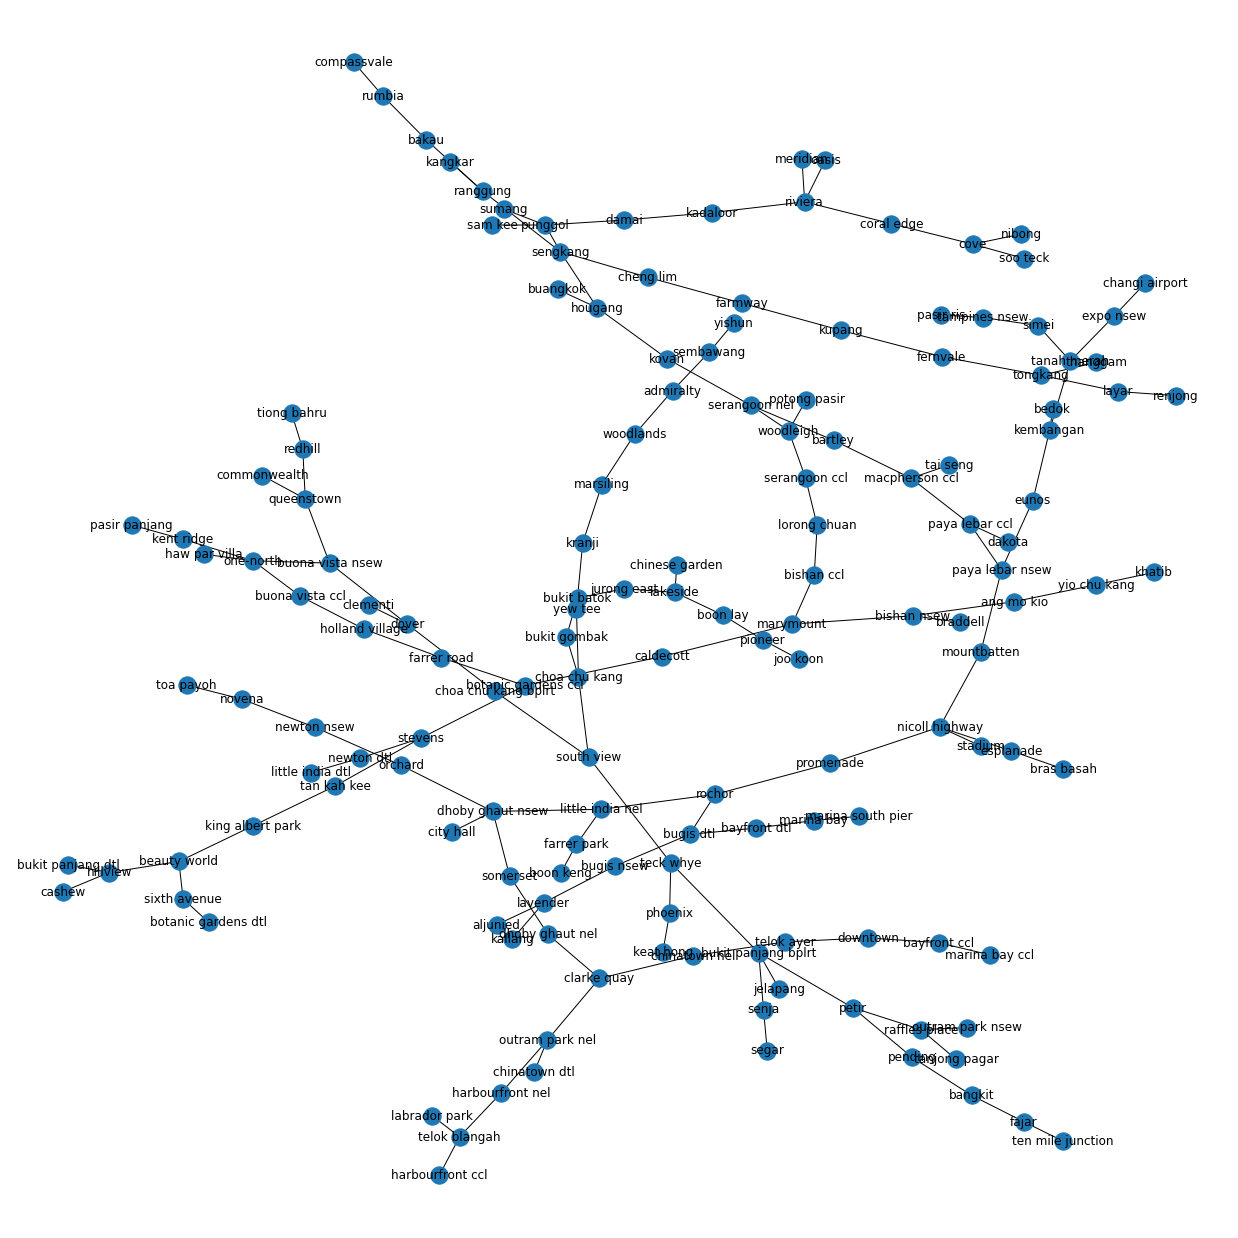

In [51]:
import networkx as nx
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)

fig = plt.figure(1, figsize=(17, 17))
nx.draw(G, pos=pos, with_labels=True, font_weight='normal')

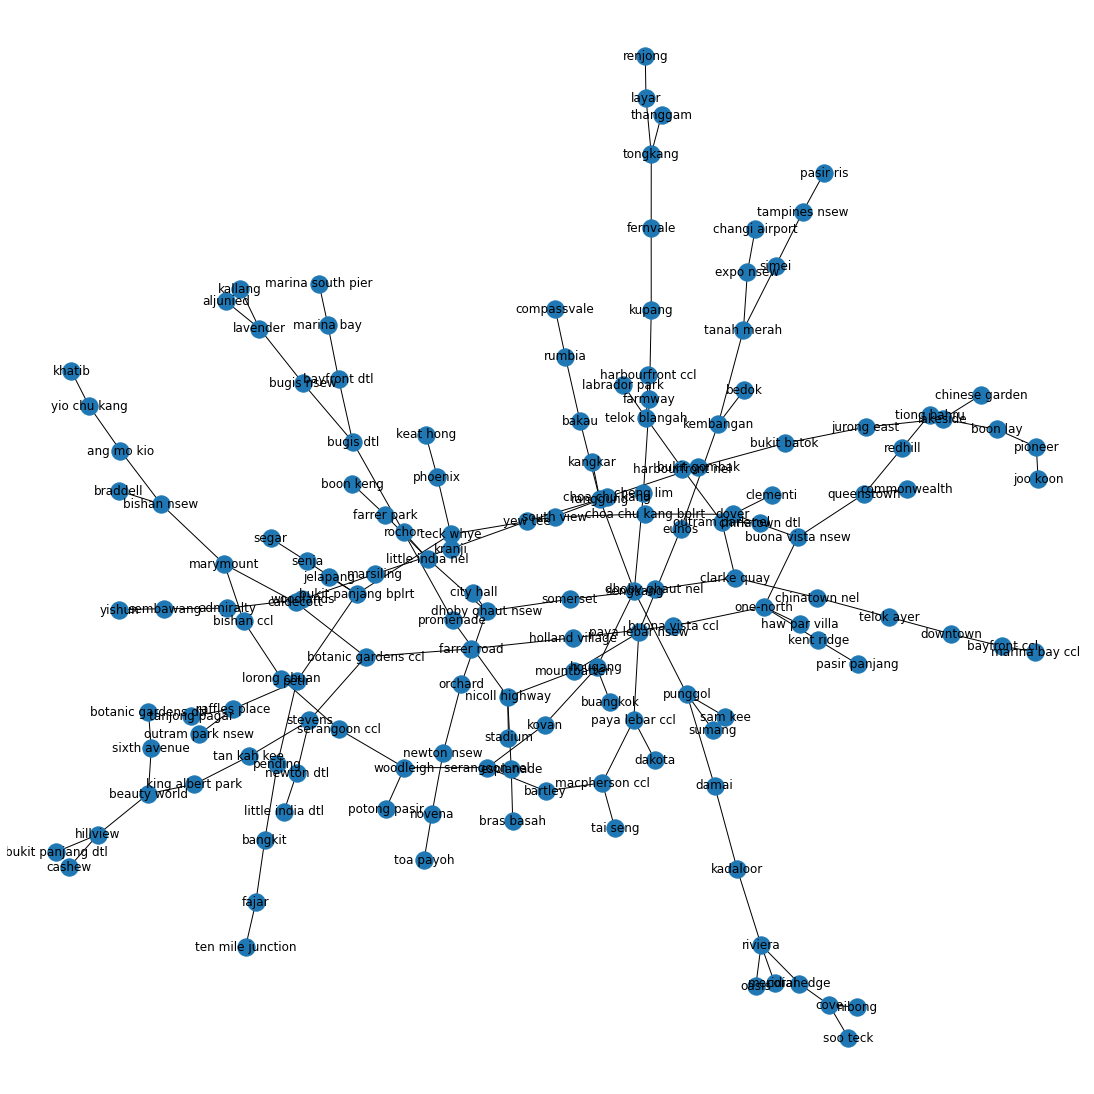

In [52]:
# another perspective
pos = nx.spring_layout(G)

fig = plt.figure(1, figsize=(15, 15))
nx.draw(G, pos=pos, with_labels=True, font_weight='light')

### q2

In [53]:
''' 
Given an origin and destination station pair (say Station A and Station B), how many trains
travelled from Station A to Station B in the given dataset? You may refer to the actual MRT
network from official sources.

'''

' \nGiven an origin and destination station pair (say Station A and Station B), how many trains\ntravelled from Station A to Station B in the given dataset? You may refer to the actual MRT\nnetwork from official sources.\n\n'

In [54]:
# we have already prepared the data structure to store the counts
count_source_to_dest

{'stevensbugis dtl': 36,
 'sengkangkent ridge': 102,
 'compassvaletai seng': 18,
 'bishan nsewlabrador park': 15,
 'boon layjoo koon': 342,
 'khatibchoa chu kang': 93,
 'woodlandssembawang': 294,
 'chinatown nelfernvale': 21,
 'newton dtlclarke quay': 24,
 'tampines nsewtanjong pagar': 540,
 'king albert parknewton dtl': 168,
 'haw par villaone-north': 243,
 'fajarsegar': 21,
 'tiong bahruclementi': 219,
 'woodlandskhatib': 78,
 'segarfajar': 21,
 'bedokbugis nsew': 645,
 'bukit batokboon lay': 183,
 'aljuniedbugis nsew': 366,
 'potong pasirtai seng': 30,
 'bukit gombaktiong bahru': 63,
 'pasir riskent ridge': 60,
 'newton dtlchinatown nel': 45,
 'simeibugis nsew': 321,
 'bukit gombakbugis nsew': 66,
 'serangoon nelkent ridge': 216,
 'woodlandsjurong east': 660,
 'punggollorong chuan': 21,
 'dovertanjong pagar': 111,
 'pioneerchinatown nel': 108,
 'yew teetoa payoh': 114,
 'dhoby ghaut nsewharbourfront nel': 12,
 'pasir risdhoby ghaut nsew': 81,
 'chinatown nelpromenade': 78,
 'choa ch

In [55]:
# i will just create a function to facilitate the search
def find_num_trains(stn_a, stn_b):
    stn_a = stn_a.lower().strip()
    stn_b = stn_b.lower().strip() 
    try:
        print("Num trains from",stn_a,"to",stn_b,":",count_source_to_dest[(stn_a+stn_b)])
    except:
        try:
            print("Num trains from",stn_a,"to",stn_b,":",count_source_to_dest[(stn_b+stn_a)])
        except:
            print("No samples found between those two station")

In [56]:
# we do a search for num samples from dhoby ghaut nel to sengkang
find_num_trains('dhoby ghaut nel', 'sengkang')

Num trains from dhoby ghaut nel to sengkang : 9


### q3

In [57]:
'''
Suppose a commuter wants to board a train at Clementi Station at 9:25 am and alight at
Kallang Station. 
Can you determine the number of people in the train at every station along the
path from Clementi to Kallang starting from 9:25 am? You may refer to the actual MRT network
from official sources.
'''

# use population living there
# still have to determine number of people that alight there

'\nSuppose a commuter wants to board a train at Clementi Station at 9:25 am and alight at\nKallang Station. \nCan you determine the number of people in the train at every station along the\npath from Clementi to Kallang starting from 9:25 am? You may refer to the actual MRT network\nfrom official sources.\n'

##### I will approach this problem as such:

1) To find the number of people at station, I will based this figure on number of people living at that area

2) Next, get total pop of Singapore, get % of people that takes MRT

3) Split the dataset given to me into time intervals, also group the dataset by the origin/dest station
   then find the % of people at this station in this time interval based on the dataset
   
4) multiply all these values together


##### Some problems:
1) This problem is not that simple as we have to account for riders that has a station as their origin 

(as in they live in the vicinity and takes the bus or walk to the station)

2) as well as those riders that change line or to bus or walk, and hence has a station as their dest

- so how I am accounting for those riders that have to change lines in midst of their travel
- is by adding the % of people at a station as the dest, during a time interval, 
- multiplied against the number of people staying at that area 
- (unfortunately, I have to use the number of people staying at that area as I have no other info that tells me of how many people work at an area, so this will in some way become a heuristic measure

3) I am using work pop % and this does not cater for schooling pop which if included, will increase the num people
   
   However, getting this figure is not easy as I will have to identify what schools are near the MRT

In [58]:
# get pop staying near these MRT stations
q3_pop_dict = {
    'clementi': 91990,
    'dover': 95930,
    'buona vista': 950930, # buona vista ccl, buona vista nsew
    'common wealth': 95930,
    'queenstown': 95930,
    'redhill': 151250,
    'tiong bahru': 151250,
    'outram park': 1830, #outram park nel, outram park nsew
    'tanjong pagar': 151250,
    'raffles place': 3190,
    'city hall': 3190,
    'bugis': 3190, # bugis dtl, bugis nsew\
    'lavender': 101290,
    'kallang': 121850   
}

In [59]:
# convert the time to a format that allows for numberic operations
original_df[['destination_tm', 'origin_tm']] = \
    original_df[['destination_tm', 'origin_tm']].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S'))

In [60]:
# lets look at how the formatting went
# the time columns are in year 1900 but it doesnt matter as we are only concerned with the time (hours, minutes, seconds)
original_df[original_df['destination'] == 'Kallang']

,index,destination,destination_tm,origin,origin_tm,time_taken_secs
57,57,Kallang,1900-01-01 09:27:57,Paya Lebar CCL,1900-01-01 09:21:19,398.0
1082,1082,Kallang,1900-01-01 10:11:47,Bukit Batok,1900-01-01 09:25:07,2800.0
1156,1156,Kallang,1900-01-01 09:47:56,Yishun,1900-01-01 09:07:32,2424.0
1382,1382,Kallang,1900-01-01 10:07:08,Changi Airport,1900-01-01 09:28:59,2289.0
2033,2033,Kallang,1900-01-01 10:28:50,Changi Airport,1900-01-01 09:54:10,2080.0
...,...,...,...,...,...,...
378716,378716,Kallang,1900-01-01 09:48:55,Changi Airport,1900-01-01 09:20:18,1717.0
379648,379648,Kallang,1900-01-01 09:47:43,Raffles Place,1900-01-01 09:36:35,668.0
379805,379805,Kallang,1900-01-01 10:23:45,Tampines NSEW,1900-01-01 09:52:22,1883.0
380108,380108,Kallang,1900-01-01 09:27:54,Paya Lebar NSEW,1900-01-01 09:19:51,483.0


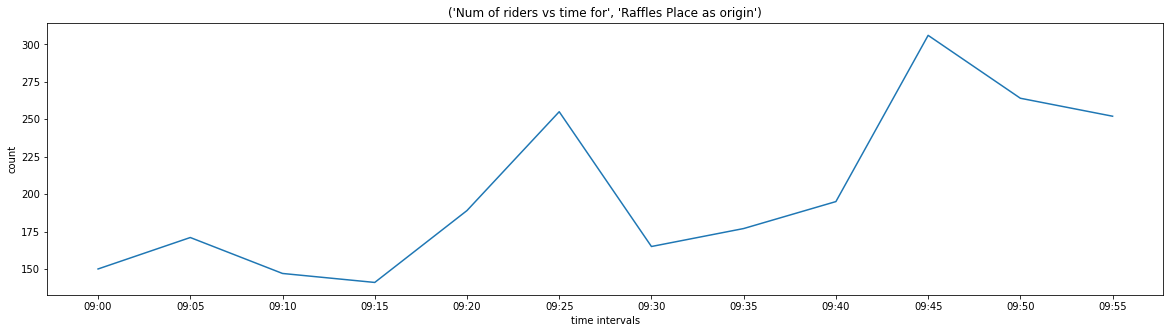

Num of percent 0.061 of people having raffles place as their origin


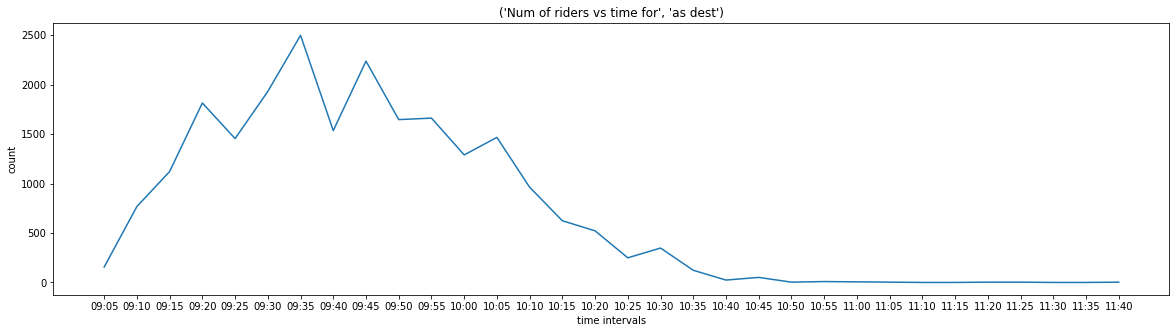

Num of percent 0.034 of people having raffles place as their dest


In [61]:
# I create a function to find % of people at a station during a time interval
def get_percent_people_during_time(stn_name, time, origin=True, graph=True):
    if stn_name[0] != stn_name[0].upper():
        stn_name = stn_name.title()

    if origin:
        subset_df = original_df[['origin', 'origin_tm']]
        subset_df = subset_df[subset_df['origin'] == stn_name]
        subset_df = subset_df.set_index('origin_tm')
        
        # if not subset_df
        # try nel, ccl, nsew
    else:
        subset_df = original_df[['destination', 'destination_tm']]
        subset_df = subset_df[subset_df['destination'] == stn_name]
        subset_df = subset_df.set_index('destination_tm')
    
    interval_observations = 0
    total_observations = len(subset_df.index)
    if total_observations == 0: return interval_observations
    
    subset_df = subset_df.resample("5T").size()
    if graph:
        temp = subset_df.reset_index()
        temp.columns = ['time_interval', 'count']
        x = temp['time_interval']
        x = [str(x[i])[11:16] for i in range(len(x))]
        y = temp['count']

        f = plt.figure()
        f.set_figwidth(20)
        f.set_figheight(5)
        plt.plot(x,y)
        title = 'Num of riders vs time for',stn_name + " as origin" if origin else "as dest"
        plt.title(title)
        plt.xlabel('time intervals')
        plt.ylabel('count')
        plt.show()
    
    input_hour = int(time[:time.index(":")])
    input_minute = time[time.index(":")+1:]
    input_minute = int(input_minute[:input_minute.index(":")])
    
    for i in range(len(subset_df.index)):
        hour = int(subset_df.index[i].hour)
        minute = int(subset_df.index[i].minute)
        second = int(subset_df.index[i].second)
        if input_hour == hour and minute <= input_minute and (minute+5) >= input_minute:
            interval_observations = subset_df[i]
            break
    
    return(round(interval_observations/total_observations,3))

time = '09:12:00'

# we see that using raffles place as an origin station, 
percent = get_percent_people_during_time('raffles place', time, True)
print("Num of percent",percent,"of people having raffles place as their origin")

percent = get_percent_people_during_time('raffles place', time, False)
print("Num of percent",percent,"of people having raffles place as their dest")

In [62]:
# now we can find % of people in clementi at station during time,
# we can proceed

In [63]:
# Clementi to Kallang takes 32 minutes
# 32 minutes across 13 stations
# 2.46 minutes each station ~ 00:02:28

In [64]:
TOTAL_POP = 5686000 # 2020
MRT_POP = 2100000 # 2021
WORKING_POP = 3710000 # 202

WORKING_PERCENT = WORKING_POP/TOTAL_POP
MRT_PERCENT = MRT_POP/TOTAL_POP
USE_PERCENT = MRT_PERCENT*WORKING_PERCENT

stations = ['clementi',
    'dover',
    'buona vista',
    'commonwealth',
    'queenstown',
    'redhill',
    'tiong bahru',
    'outram park',
    'tanjong pagar',
    'raffles place',
    'city hall',
    'bugis',
    'lavender',
    'kallang']

print(USE_PERCENT) # this is the main percent i will use for computing number of people at a station

0.24097916413294698


In [65]:
# here we store all the pop count at each station
# Source: https://www.citypopulation.de/en/singapore/admin/


q3_pop_dict = {
    'clementi': 91990,
    'dover': 95930,
    'buona vista': 31976, # buona vista ccl, buona vista nsew
    'buona vista ccl': 31976,
    'buona vista nsew': 31976,
    'commonwealth': 31976,
    'queenstown': 31976,
    'redhill': 75625,
    'tiong bahru': 75625,
    'outram park': 1830, #outram park nel, outram park nsew
    'outram park nel': 1830,
    'outram park nsew': 1830,
    'tanjong pagar': 151250,
    'raffles place': 3190,
    'city hall': 3190,
    'bugis': 3190, # bugis dtl, bugis nsew\
    'bugis dtl': 3190,
    'bugis nsew': 3190,
    'lavender': 101290,
    'kallang': 121850   
}

In [66]:
name_to_id

{'bugis dtl': 0,
 'kent ridge': 1,
 'tai seng': 2,
 'labrador park': 3,
 'joo koon': 4,
 'choa chu kang': 5,
 'sembawang': 6,
 'fernvale': 7,
 'clarke quay': 8,
 'tanjong pagar': 9,
 'newton dtl': 10,
 'one-north': 11,
 'segar': 12,
 'clementi': 13,
 'khatib': 14,
 'fajar': 15,
 'bugis nsew': 16,
 'boon lay': 17,
 'tiong bahru': 18,
 'chinatown nel': 19,
 'jurong east': 20,
 'lorong chuan': 21,
 'toa payoh': 22,
 'harbourfront nel': 23,
 'dhoby ghaut nsew': 24,
 'promenade': 25,
 'pioneer': 26,
 'buona vista ccl': 27,
 'stadium': 28,
 'woodlands': 29,
 'sengkang': 30,
 'harbourfront ccl': 31,
 'pasir panjang': 32,
 'lavender': 33,
 'queenstown': 34,
 'kallang': 35,
 'raffles place': 36,
 'nicoll highway': 37,
 'tampines nsew': 38,
 'outram park nsew': 39,
 'potong pasir': 40,
 'city hall': 41,
 'tanah merah': 42,
 'somerset': 43,
 'dover': 44,
 'buangkok': 45,
 'admiralty': 46,
 'serangoon ccl': 47,
 'yew tee': 48,
 'downtown': 49,
 'orchard': 50,
 'farrer road': 51,
 'aljunied': 52,
 

In [67]:
from datetime import datetime, time
from datetime import timedelta

current_time = '09:25:00'
time_between_stn = '00:02:28'

new_time = datetime.strptime(current_time, '%H:%M:%S').time()
time_between_stn = datetime.strptime(time_between_stn, '%H:%M:%S').time()
x = []
y = []

def compute_num_people(stations, current_time, new_time, new_name=None):
    for stn in stations:
        pop = q3_pop_dict[stn]
        mrt_working_pop = USE_PERCENT * pop
        if new_name: 
            origin_percent = get_percent_people_during_time(new_name, current_time, True, False)
            dest_percent = get_percent_people_during_time(new_name, current_time, False, False)
        else: 
            origin_percent = get_percent_people_during_time(stn, current_time, True, False)
            dest_percent = get_percent_people_during_time(stn, current_time, False, False)
        
        num_people = int(mrt_working_pop * (origin_percent+dest_percent/2))
        print("Num people (",stn,":",current_time,"):", num_people)
        if num_people > 0:
            x.append(stn+"\n"+str(current_time))
            y.append(num_people)
        
        current_hour = new_time.hour
        current_minute = new_time.minute
        current_second = new_time.second

        add_minute = time_between_stn.minute
        add_second = time_between_stn.second

        if add_second + current_second >= 60:
            current_minute += 1
            current_second = (add_second + current_second) - 60

            if add_minute + current_minute >= 60:
                current_hour += 1
                current_minute = (add_minute + current_minute) - 60

                new_time =  time(current_hour, current_minute, current_second)
            else:
                new_time =  time(current_hour, current_minute + add_minute, current_second)
        else:
            new_time =  time(current_hour, current_minute + add_minute, current_second + add_second)
        current_time = str(new_time)
    
compute_num_people(stations, current_time, new_time)

Num people ( clementi : 09:25:00 ): 2848
Num people ( dover : 09:27:28 ): 2438
Num people ( buona vista : 09:29:56 ): 0
Num people ( commonwealth : 09:32:24 ): 1325
Num people ( queenstown : 09:34:52 ): 1086
Num people ( redhill : 09:37:20 ): 2551
Num people ( tiong bahru : 09:39:48 ): 2095
Num people ( outram park : 09:42:16 ): 0
Num people ( tanjong pagar : 09:44:44 ): 4865
Num people ( raffles place : 09:47:12 ): 135
Num people ( city hall : 09:49:40 ): 115
Num people ( bugis : 09:52:08 ): 0
Num people ( lavender : 09:54:36 ): 3307
Num people ( kallang : 09:57:04 ): 3127


#### We get 0 for buona vista, outram and bugis because their names are stored differently in the dataset
i.e. buona vista is stored as buona vista ccl or nsew
below we fix for that issue

the numbers computed we can add them together to represent for that one station

In [68]:
# buona vista, outram and bugis give 0 because their name is stored differently
# we compute for their values here

troublesome_names = {'buona vista': ['Buona Vista CCL', 'Buona Vista NSEW'],
                     'outram park': ['Outram Park NSEW', 'outram park NEL'],
                     'bugis': ['Bugis DTL', 'Bugis NSEW']
                    }

for stn in troublesome_names['buona vista']:
    compute_num_people(['buona vista'], '09:29:56', datetime.strptime('09:29:56', '%H:%M:%S').time(), new_name=stn)
    
for stn in troublesome_names['outram park']:
    compute_num_people(['outram park'], '09:42:16', datetime.strptime('09:42:16', '%H:%M:%S').time(), new_name=stn)
    
for stn in troublesome_names['bugis']:
    compute_num_people(['bugis'], '09:42:16', datetime.strptime('09:42:16', '%H:%M:%S').time(), new_name=stn)   

Num people ( buona vista : 09:29:56 ): 1178
Num people ( buona vista : 09:29:56 ): 1063
Num people ( outram park : 09:42:16 ): 47
Num people ( outram park : 09:42:16 ): 0
Num people ( bugis : 09:42:16 ): 87
Num people ( bugis : 09:42:16 ): 99


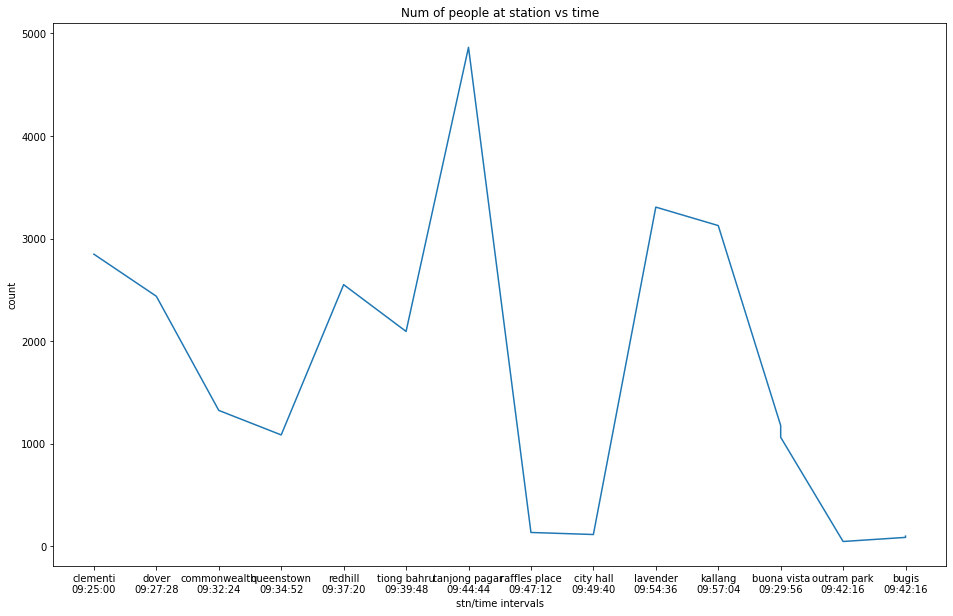

In [69]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
plt.plot(x,y)
plt.title('Num of people at station vs time')
plt.xlabel('stn/time intervals')
plt.ylabel('count')
plt.show()

# generally, we see that as the morning gets later and the further down the line we go
# num of people generally decrease

# we see areas where there are more offices, and also stations where the lines can be changed as having more people
# less raffles place and city hall, which the issue is talked about below

##### Overall, for some stations we get a good estimation of the number of people at that time

However, for some other stations like raffles place, city hall,

these stations normally people dont live them so it is expected for them to be recorded as origin to be low 

unless the people there are going hour after work, but the times we are constrained to is at 9 am


#### This is also the inherent flaw of this method of estimation as in our q3_pop_dict, raffles place etc.. only have a pop of few thousand

#### this method can be improved if we know roughly how many workers are employed near that mrt as opposed to how many people are living in that area

